In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sqlalchemy
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine

import squarify


def create_db(user="root", password="msql1234", server="localhost", database="transact"):
    SQLALCHEMY_DATABASE_URL = "mysql+pymysql://{}:{}@{}/{}".format(
        user, password, server, database
    )
    engine = create_engine(SQLALCHEMY_DATABASE_URL)

    SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
    Base = declarative_base()

    return engine, SessionLocal, Base

engine, SessionLocal, Base = create_db()

/tmp/ipykernel_43601/3499003421.py:21: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


# Fetch Data

In [2]:
with engine.connect() as db:
	query_string = sqlalchemy.text(
		"""SELECT u.*, t.date,
		t.amount, t.errors,
		t.use_chip, t.zip
		FROM users u, transactions t
		WHERE u.user = t.user
		ORDER BY t.user; """
	)
	fetched = pd.DataFrame(db.execute(query_string).fetchall())
	db.close()


fetched['day'] = fetched['date'].dt.day
fetched['month'] = fetched['date'].dt.month
fetched['year'] = fetched['date'].dt.year
fetched

,user,person,current_age,retirement_age,birth_year_month,gender,address,apartment,city,state,...,fico_score,num_credit_cards,date,amount,errors,use_chip,zip,day,month,year
0,0000000000,Hazel Robinson,53,66,1966-11-01,Female,462 Rose Lane,NaN,La Verne,CA,...,787.0,5,2005-10-25 16:34:00,113.81,None,Swipe Transaction,91750,25,10,2005
1,0000000000,Hazel Robinson,53,66,1966-11-01,Female,462 Rose Lane,NaN,La Verne,CA,...,787.0,5,2007-08-29 06:36:00,44.99,None,Swipe Transaction,91755,29,8,2007
2,0000000000,Hazel Robinson,53,66,1966-11-01,Female,462 Rose Lane,NaN,La Verne,CA,...,787.0,5,2010-08-08 06:10:00,113.09,None,Online Transaction,None,8,8,2010
3,0000000000,Hazel Robinson,53,66,1966-11-01,Female,462 Rose Lane,NaN,La Verne,CA,...,787.0,5,2005-07-12 13:07:00,13.30,None,Swipe Transaction,91750,12,7,2005
4,0000000000,Hazel Robinson,53,66,1966-11-01,Female,462 Rose Lane,NaN,La Verne,CA,...,787.0,5,2016-08-16 06:11:00,161.26,None,Swipe Transaction,91750,16,8,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0000001998,Juelz Roman,66,60,1954-02-01,Male,259 Valley Boulevard,NaN,Camp Hill,PA,...,618.0,1,2017-01-04 15:12:00,12.69,None,Swipe Transaction,17011,4,1,2017
9996,0000001998,Juelz Roman,66,60,1954-02-01,Male,259 Valley Boulevard,NaN,Camp Hill,PA,...,618.0,1,2018-05-27 23:04:00,473.00,None,Online Transaction,None,27,5,2018
9997,0000001998,Juelz Roman,66,60,1954-02-01,Male,259 Valley Boulevard,NaN,Camp Hill,PA,...,618.0,1,2014-02-19 18:59:00,35.93,None,Online Transaction,None,19,2,2014
9998,0000001999,Kenia Harris,21,60,1998-11-01,Female,472 Ocean View Street,NaN,Merrimack,NH,...,673.0,2,2018-03-11 08:04:00,29.68,None,Chip Transaction,3054,11,3,2018


# RFM Calculation

## Recency

In [3]:
def get_RFM(data, group=["day", "month", "year"], 
		seg_map = {
			r'[1-2][1-2]': 'Hibernating',
			r'[1-2][3-4]': 'At Risk',
			r'[1-2]5': 'Cannot Lose',
			r'3[1-2]': 'About to Sleep',
			r'33': 'Need Attention',
			r'[3-4][4-5]': 'Loyal Customers',
			r'41': 'Promising',
			r'51': 'New Customers',
			r'[4-5][2-3]': 'Potential Loyalists',
			r'5[4-5]': 'Champions'
		}
	):
	data = data.sort_values(by=group)
	recency = (data['date'].max() - data.groupby(['user'] +  group).agg({"date":"max"})).rename(columns = {"date":"recency"})
	recency['recency'] = recency['recency'].apply(lambda x: x.days)
	recency = recency.reset_index()
	frequency = (data.groupby(['user'] + group).agg({"date":"nunique"})).rename(columns = {"date":"frequency"}).reset_index()
	# print(frequency)
	monetary = fetched.groupby(["user"] + group).agg({"amount":"sum"}).rename(columns = {"amount":"monetary"}).reset_index()
	
	rfm = recency.merge(frequency, how='outer', on=(['user'] +  group)).merge(monetary, how='outer', on=(['user'] +  group))

	rfm['recency_score'] = pd.qcut(rfm["recency"], 5, labels = [5,4,3,2,1])
	rfm['frequency_score'] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
	rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels = [1, 2, 3, 4, 5])
	rfm['rfm_score'] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str))

	rfm['segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)
	rfm['segment'] = rfm['segment'].replace(seg_map, regex=True)
	return rfm
rfm = get_RFM(fetched, group=[])
rfm

,user,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,segment
0,0000000000,1291,6,642.55,2,3,5,235,At Risk
1,0000000001,1269,3,48.72,2,1,1,211,Hibernating
2,0000000002,629,19,472.82,3,5,5,355,Loyal Customers
3,0000000003,2759,5,1725.14,1,3,5,135,At Risk
4,0000000004,275,10,382.02,4,5,4,454,Loyal Customers
...,...,...,...,...,...,...,...,...,...
1562,0000001995,31,6,94.62,5,4,2,542,Champions
1563,0000001996,2052,6,151.04,1,4,3,143,At Risk
1564,0000001997,883,5,92.24,2,3,2,232,At Risk
1565,0000001998,514,4,536.02,3,3,5,335,Need Attention


In [ ]:
def get_RFM_stats(rfm):
	rfm_stats = rfm[["segment","recency","frequency", "monetary"]].groupby("segment").agg(["mean","median","count", "std"])
	rfm_stats.columns = rfm_stats.columns.map('_'.join).str.strip('|')	
	return rfm_stats

rfm_stats = get_RFM_stats(rfm)
rfm_stats

,recency_mean,recency_median,recency_count,recency_std,frequency_mean,frequency_median,frequency_count,frequency_std,monetary_mean,monetary_median,monetary_count,monetary_std
segment,,,,,,,,,,,,
About to Sleep,592.253012,587.0,83,110.010958,2.783133,3.0,83,0.988324,119.025783,81.010,83,119.299097
At Risk,1507.250000,1312.5,204,607.729005,6.308824,6.0,204,1.402925,291.138088,246.850,204,238.559128
Cannot Lose,1301.315789,1095.0,57,577.365945,12.087719,11.0,57,3.536951,452.652456,388.130,57,343.672767
Champions,86.608187,81.0,171,50.744849,11.514620,10.0,171,5.271853,447.776316,364.180,171,362.571131
Hibernating,1982.765027,1646.5,366,1108.143272,2.497268,2.0,366,1.061786,105.724399,83.210,366,137.537582
Loyal Customers,431.977273,412.0,308,169.275298,10.993506,9.0,308,4.241100,472.035455,394.305,308,350.454050
Need Attention,596.974684,605.0,79,99.366580,5.354430,5.0,79,0.599957,282.693418,252.220,79,201.447717
New Customers,59.803922,42.0,51,54.634795,1.294118,1.0,51,0.460179,34.622353,33.450,51,93.533305
Potential Loyalists,194.889423,191.5,208,115.226189,4.668269,5.0,208,1.077012,216.529135,183.005,208,198.789105


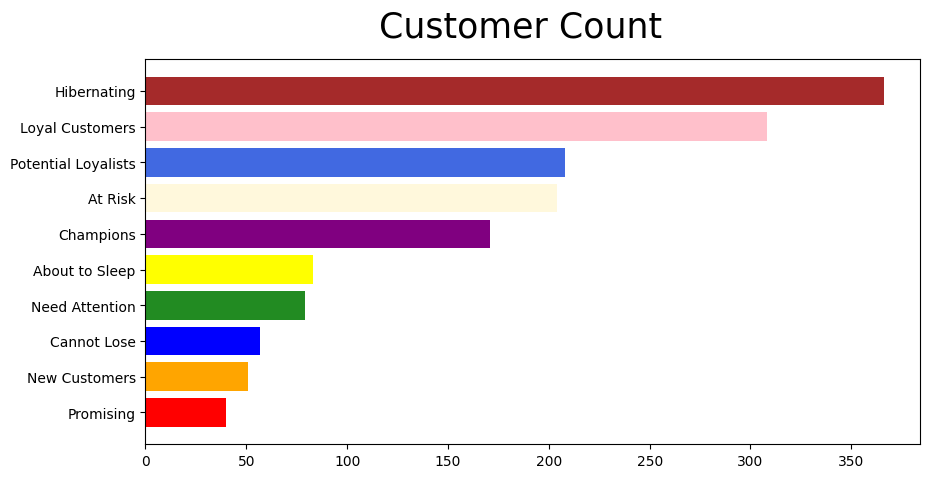

In [5]:
def plt_RFM_segments(rfm_stats):
	rfm_stats = rfm_stats.sort_values(by=['recency_count'], ascending=True)
	plt.figure(figsize = (10,5))
	# squarify.plot(sizes=rfm_stats.recency_count, label=rfm_stats.index, 
	# 	color=["red","orange","blue", "forestgreen", "yellow", "purple", "cornsilk","royalblue", "pink", "brown"], alpha=.4 )
	plt.barh(rfm_stats.index, rfm_stats['recency_count'],
		color=["red","orange","blue", "forestgreen", "yellow", "purple", "cornsilk","royalblue", "pink", "brown"])
	
	plt.suptitle("Customer Count", fontsize=25)
	plt.show()

plt_RFM_segments(rfm_stats)

- user
- current_age
- yearly_income
- total_debt
- gender

In [6]:
rfm_fetched = rfm.merge(fetched, how='left', on=["user"])

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

def get_XY(data, subset = 'demo', le=LabelEncoder()):
	if subset == 'demo':
		data['gender'] = le.fit_transform(data['gender'])
		data['segment'] = le.fit_transform(data['segment'])
	X = data[['current_age', 'yearly_income', 'total_debt', 'gender']]
	# X.reset_index(inplace=True)
	y = data['segment']
	# y.reset_index(inplace=True)
	return X, y



rfm_X, rfm_y = get_XY(rfm_fetched)	
X_train, X_test, y_train, y_test = train_test_split(rfm_X, rfm_y, test_size=0.2)
X_train, y_train

(      current_age  yearly_income  total_debt  gender
 9491           46        32150.0     47179.0       0
 5710           82        22726.0      1692.0       0
 2182           66        38249.0         0.0       0
 4222           45        38872.0     94970.0       0
 2101           49        38041.0     27813.0       1
 ...           ...            ...         ...     ...
 4405           33        37384.0     49182.0       0
 1491           88        19225.0      1644.0       0
 4128           39        58774.0     94053.0       0
 5978           44        44816.0     63043.0       1
 7627           66        74059.0    144396.0       1
 
 [8000 rows x 4 columns],
 9491    3
 5710    3
 2182    5
 4222    2
 2101    1
        ..
 4405    5
 1491    5
 4128    5
 5978    8
 7627    5
 Name: segment, Length: 8000, dtype: int64)

In [7]:
from xgboost import XGBRFClassifier
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
rfm_model = XGBRFClassifier(base_score=0.5, booster='gbtree',
						n_estimators=100,
						objective='multi:softmax',
						max_depth=7,
						learning_rate=0.001,
						enable_categorical=True,
						device='cuda',
						verbosity=2)
for train_index, test_index in kf.split(X_train, y_train):
	rfm_model.fit(X_train.iloc[train_index, :], y_train.iloc[train_index])

rfm_model

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device='cuda',
                early_stopping_rounds=None, enable_categorical=True,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.001, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, objective='multi:softmax',
                random_state=None, ...)

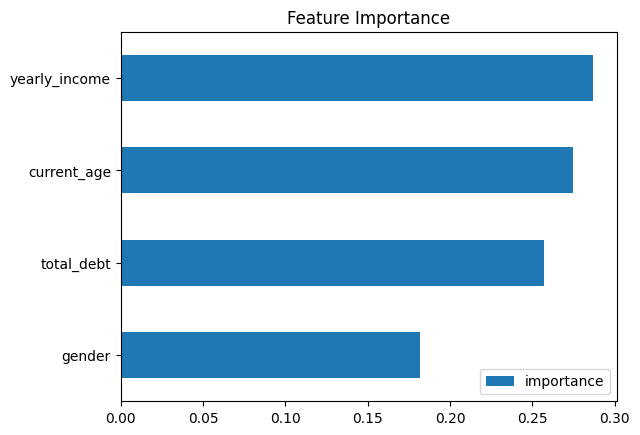

In [8]:
fig = pd.DataFrame(data=rfm_model.feature_importances_,
             index=rfm_model.feature_names_in_,
             columns=['importance'])
fig.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [9]:
# rfm_model.predict(test_X)
from sklearn.metrics import classification_report, confusion_matrix
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    return cm, class_report

cm, class_report = evaluate(y_test, rfm_model.predict(X_test)) 
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.06      0.11        51
           1       0.77      0.32      0.45       262
           2       0.88      0.36      0.51       143
           3       0.73      0.59      0.65       378
           4       0.63      0.21      0.31       180
           5       0.49      0.98      0.65       679
           6       0.93      0.17      0.29        82
           7       0.75      0.43      0.55        14
           8       0.68      0.27      0.39       201
           9       0.00      0.00      0.00        10

    accuracy                           0.57      2000
   macro avg       0.69      0.34      0.39      2000
weighted avg       0.66      0.57      0.53      2000



/home/ekmi00/anaconda3/envs/torchdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:24:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/ekmi00/anaconda3/envs/torchdev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ekmi00/anaconda3/envs/torchdev/lib/python3.10/site-packages/sklearn/m